In [1]:
from google.colab import files

# Upload the zipped folder
uploaded = files.upload()

Saving PlantVillage.zip to PlantVillage.zip


In [18]:
import zipfile

zip_path = '/content/PlantVillage.zip'  # Path to the uploaded zip file

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.printdir()  # List the contents of the zip file


File Name                                             Modified             Size
PlantVillage/Potato___Early_blight/            2025-01-26 21:08:38            0
PlantVillage/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136.JPG 2025-01-26 10:23:26        21057
PlantVillage/Potato___Early_blight/042135e2-e126-4900-9212-d42d900b8125___RS_Early.B 8791.JPG 2025-01-26 10:23:26        18355
PlantVillage/Potato___Early_blight/0604174e-3018-4faa-9975-0be32d2c0789___RS_Early.B 7123.JPG 2025-01-26 10:23:26        21124
PlantVillage/Potato___Early_blight/07953ca1-8935-449f-b338-4357ed683b2d___RS_Early.B 6815.JPG 2025-01-26 10:23:26        19877
PlantVillage/Potato___Early_blight/08029ccc-387e-4be6-9389-04f7b82fdb2a___RS_Early.B 9130.JPG 2025-01-26 10:23:26        20456
PlantVillage/Potato___Early_blight/08194ca3-f0b2-4aaa-8df8-5ec5ddc6696a___RS_Early.B 8151.JPG 2025-01-26 10:23:26        21019
PlantVillage/Potato___Early_blight/08392b44-ecc6-4f38-8566-361b552cfe21___RS_E

In [19]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')  # Extract the contents directly to /content


In [20]:
print(os.listdir('/content/PlantVillage'))



['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'PlantVillage']


Import Libraries Importing necessary libraries and modules required to build the classification model.

In [5]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    Activation,
    Flatten,
    Dropout,
    Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


Load Dataset Initializing a few parameters required for the image dataset preprocessing.

In [6]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

We use the function convert_image_to_array to resize an image to the size DEFAULT_IMAGE_SIZE we defined above.

In [7]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Here, we load the training data images by traversing through all the folders and converting all the images and labels into separate lists respectively.

NOTE: We use a small portion of the entire dataset due to the computing limitations. Tweak N_IMAGES to include entire dataset.

In [22]:
import os
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

# Default image size for resizing
DEFAULT_IMAGE_SIZE = (256, 256)

# Function to convert an image to an array
def convert_image_to_array(image_path):
    try:
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)  # Resize image
            return img_to_array(image)
        else:
            return np.array([])  # Return empty array if image is not valid
    except Exception as e:
        print(f"Error reading image {image_path}: {e}")
        return None

# Path to the dataset directory
image_dir = '/content/PlantVillage'

# List of processed image arrays and their labels
image_data = []
image_labels = []

# Process each folder in the root directory
for folder_name in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder_name)
    if os.path.isdir(folder_path) and folder_name != 'PlantVillage':  # Skip 'PlantVillage' folder
        print(f"Processing folder: {folder_name}")
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):  # Ensure it's a file (not a folder)
                image_array = convert_image_to_array(file_path)
                if image_array is not None and image_array.size > 0:
                    image_data.append(image_array)
                    image_labels.append(folder_name)  # Use the folder name as the label
                else:
                    print(f"Failed to process image: {file_name}")

print(f"Processed {len(image_data)} images.")


Processing folder: Potato___Early_blight
Processing folder: Potato___Late_blight
Processing folder: Potato___healthy
Processed 1152 images.


In [25]:
import os
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

# Default image size for resizing
DEFAULT_IMAGE_SIZE = (256, 256)

# Function to convert an image to an array
def convert_image_to_array(image_path):
    try:
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)  # Resize image
            return img_to_array(image)
        else:
            return np.array([])  # Return empty array if image is not valid
    except Exception as e:
        print(f"Error reading image {image_path}: {e}")
        return None

# Path to the dataset directory
image_dir = '/content/PlantVillage'

# List of processed image arrays and their labels
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

    # Loop through each disease folder
    for plant_disease_folder in plant_disease_folder_list:
        folder_path = os.path.join(image_dir, plant_disease_folder)
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = os.listdir(folder_path)

        # Loop through each image file in the folder
        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = os.path.join(folder_path, image)
            if image_directory.endswith(".jpg") or image_directory.endswith(".JPG"):
                image_array = convert_image_to_array(image_directory)
                if image_array is not None and image_array.size > 0:
                    image_list.append(image_array)
                    label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 255.0  # Normalize pixel values
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")


[INFO] Loading images ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Image loading completed

Total number of images: 300


Examine the labels/classes in the training dataset.

In [26]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  3


Augment and Split Dataset Using ImageDataGenerator to augment data by performing various operations on the training images.

In [27]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True,
                             fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [28]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Splitting data to train and test...


In [31]:
print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training data shape: (240, 256, 256, 3)
Testing data shape: (60, 256, 256, 3)
Training labels shape: (240, 3)
Testing labels shape: (60, 3)


Build Model Defining the hyperparameters of the plant disease classification model.

In [29]:
EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [32]:
from tensorflow.keras import backend as K


In [33]:
from tensorflow.keras import backend as K  # Import K for backend functions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# Model architecture
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_classes))  # Output layer with softmax activation
model.add(Activation("softmax"))

# Show the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 85, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 85, 85, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 85, 85, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 85, 85, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 85, 85, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 85, 85, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 85, 85, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 42, 42, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 42, 42, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 42, 42, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 42, 42, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 42, 42, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 58,090,371 (221.60 MB)

 Trainable params: 58,087,491 (221.59 MB)

 Non-trainable params: 2,880 (11.25 KB)

Train Model We initialize Adam optimizer with learning rate and decay parameters.

Also, we choose the type of loss and metrics for the model and compile it for training.

In [35]:
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer

# Initialize optimizer
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)  # Use 'learning_rate' instead of 'lr'

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit(
    augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


[INFO] Training network...
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 8s/step - accuracy: 0.6573 - loss: 0.7807 - val_accuracy: 0.2667 - val_loss: 3.5064
Epoch 2/25
1/7 ━━━━━━━━━━━━━━━━━━━━ 54s 9s/step - accuracy: 0.8125 - loss: 0.4246

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 512ms/step - accuracy: 0.8125 - loss: 0.4246 - val_accuracy: 0.2667 - val_loss: 3.5562
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 8s/step - accuracy: 0.9516 - loss: 0.1909 - val_accuracy: 0.2667 - val_loss: 5.0679
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 509ms/step - accuracy: 0.8750 - loss: 0.3331 - val_accuracy: 0.2667 - val_loss: 5.6017
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.9130 - loss: 0.2148 - val_accuracy: 0.2667 - val_loss: 8.8879
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - accuracy: 0.9688 - loss: 0.0867 - val_accuracy: 0.2667 - val_loss: 9.0016
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 8s/step - accuracy: 0.9114 - loss: 0.1817 - val_accuracy: 0.2667 - val_loss: 4.5124
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 506ms/step - accuracy: 0.8438 - loss: 0.2979 - val_accuracy: 0.2667 - val_loss: 3.8672
Epoch 9/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 8s/step - accuracy: 0.9025 - loss: 0.2304 - val_accuracy: 0.2667 - val_loss: 5.6831
Epoch 1

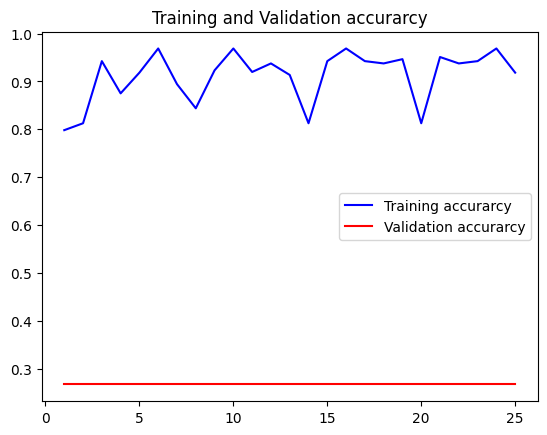

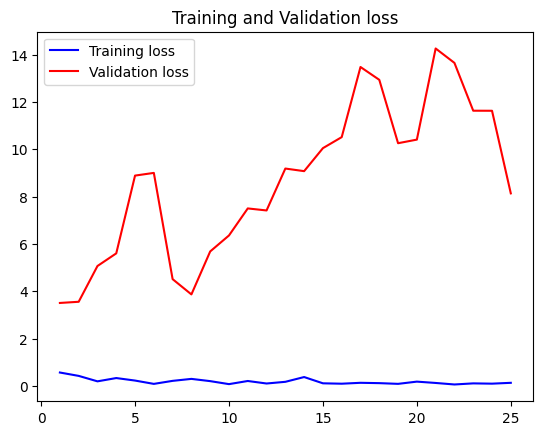

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the evaluate method

In [39]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2924 - loss: 23.3900
Test Accuracy: 26.66666805744171


Save Model

In [40]:
# Dump pickle file of the model
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...


In [41]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


Test Model We write the following predict_disease function to predict the class or disease of a plant image.

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [42]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result=np.argmax(model.predict(np_image), axis=-1)
    #result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

In [43]:
import os

plant_village_dir = '/content/PlantVillage'
subfolders = os.listdir(plant_village_dir)
print(subfolders)  # This should show the subfolders like 'Potato___Early_blight', 'Potato___Late_blight', etc.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'PlantVillage']


In [51]:
import os
import random

plant_village_dir = '/content/PlantVillage'
subfolders = os.listdir(plant_village_dir)

# Select a random folder and check its contents
random_folder = random.choice(subfolders)
folder_path = os.path.join(plant_village_dir, random_folder)

# List all the images in the folder
images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Handle case when no images are found
if not images:
    print(f"No images found in folder: {folder_path}")
else:
    random_image = random.choice(images)
    image_path = os.path.join(folder_path, random_image)
    print(f"Random image path: {image_path}")


Random image path: /content/PlantVillage/Potato___Late_blight/b65fddcf-cc40-4632-a0c4-70fff2f68009___RS_LB 4481.JPG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Potato___Late_blight


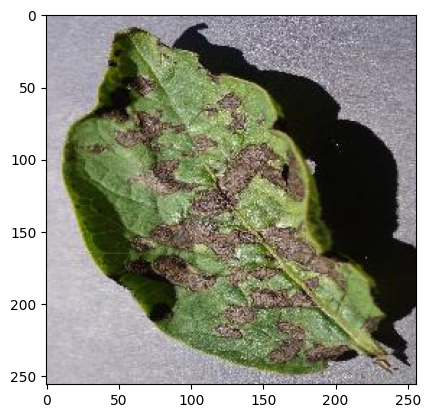

In [46]:
predict_disease('/content/PlantVillage/Potato___Early_blight/af0ee942-50f5-43a7-a9fe-486ba1f5f989___RS_Early.B 7700.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Potato___Late_blight


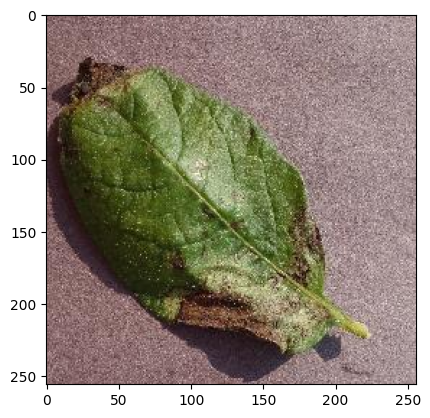

In [52]:
predict_disease('/content/PlantVillage/Potato___Late_blight/b65fddcf-cc40-4632-a0c4-70fff2f68009___RS_LB 4481.JPG')